In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/AN2DL/Progetto_2/

/gdrive/My Drive/AN2DL/Progetto_2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
#k80 lenta, t4 e p100 veloci

Wed Dec 22 12:13:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    41W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:



import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

dataset = pd.read_csv('dataset.csv')
print(dataset.shape)
dataset.head()

model_name = "H_MK_XXXIf"
window = 2048
stride = 2
telescope = 16
reg_telescope = 864
epochs = 200
batch_size = 32
#layer_size = 128
regularization = 1e-7
kernel_size = 3
dropout_rate = 0.3
clipnorm=0.01

# batch_size = random.randint(8, 1024)
# layer_size = random.randint(8, 1024)
# regularization = random.randint(1, 1000)/ 1e8
# kernel_size = random.randint(3, 17)
# dropout_value = random.randint(1, 999)/1000
# clipnorm= random.randint(10, 100)/1000

#print(batch_size,layer_size,regularization,kernel_size,dropout_value,clipnorm)


2.7.0
(68528, 7)


(61676, 7) (6852, 7)


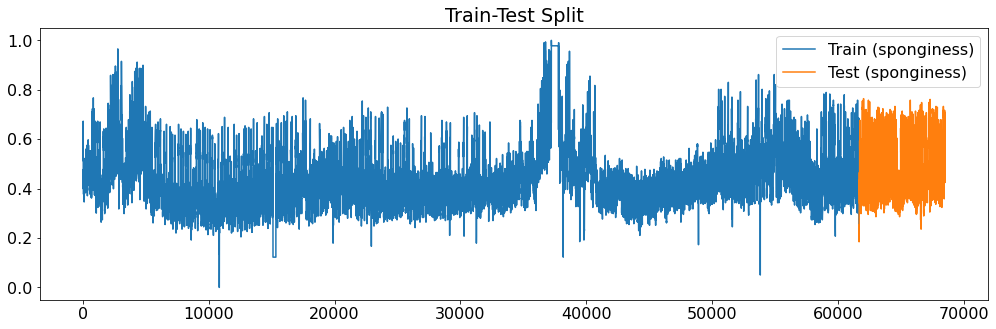

(61676, 7)
(54824, 7) (6852, 7)
(26616, 2048, 7) (26616, 16, 7) (3064, 2048, 7) (3064, 16, 7)
(53232, 2048, 7) (53232, 16, 7) (3064, 2048, 7) (3064, 16, 7) (3064, 2048, 7) (3064, 16, 7)


In [ ]:

test_size = int(dataset.shape[0]/10)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels, LO FACCIO SUL DATASET COMPLETO -------------------------------------------------------
X_min = dataset.min()
X_max = dataset.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()



'''
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape
'''

def build_sequences(df, target_labels=['sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

target_labels = dataset.columns

X_validation_raw = X_train_raw[:test_size]

print(X_train_raw.shape )
X_train_raw = X_train_raw[test_size:]
print(X_train_raw.shape, X_validation_raw.shape)


X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_valid, y_valid = build_sequences(X_validation_raw, target_labels, window, stride, telescope)

X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
autoencoder = tfk.models.load_model('Autoencoder_IIIb')
X_train_ae = autoencoder.predict(X_train)
X_train = np.concatenate((X_train, X_train_ae))
y_train = np.concatenate((y_train, y_train))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape)


input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.GaussianNoise(0.001, seed = seed)(input_layer)
    x = tfkl.Conv1D(16, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(32, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(256, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(512, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Conv1D(1024, 3, padding='same', activation='relu',kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization))(x)
    x = tfkl.MaxPool1D()(x)
    x = tfkl.Bidirectional(tfkl.LSTM(7, return_sequences=True,kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.l2(regularization)))(x)
    
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(x)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(clipnorm = clipnorm), metrics=tf.keras.metrics.RootMeanSquaredError())

    # Return the model
    return model



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2048, 7)]         0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2048, 7)          0         
 se)                                                             
                                                                 
 conv1d (Conv1D)             (None, 2048, 16)          352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1024, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1024, 32)          1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 512, 32)          0     

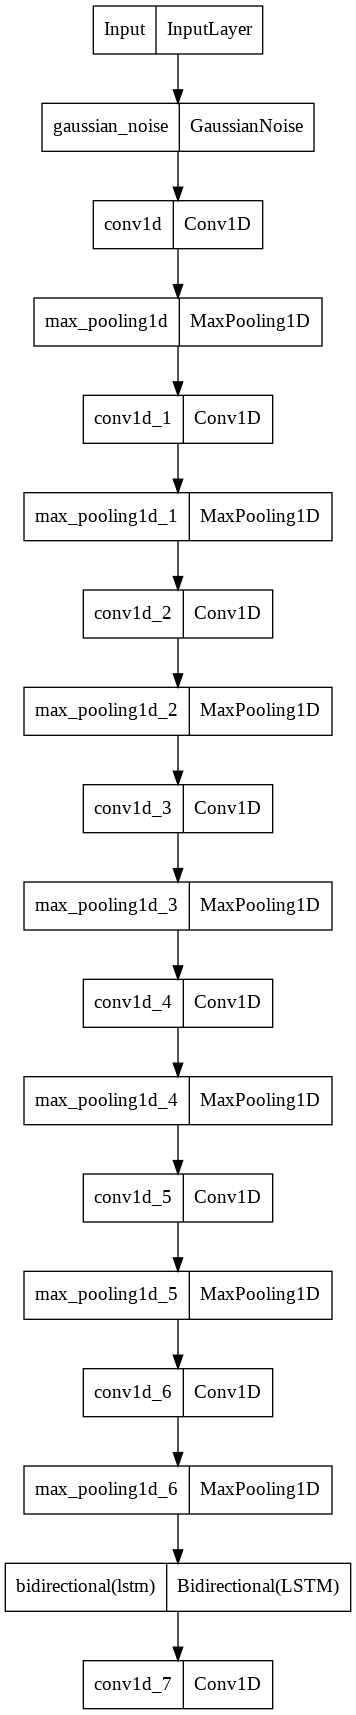

In [ ]:
    
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)



In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = [X_valid,y_valid],
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.7, min_lr=1e-5)
    ]
).history

Epoch 1/200
1664/1664 [==============================] - 32s 17ms/step - loss: 0.0082 - root_mean_squared_error: 0.0899 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1172 - lr: 0.0010
Epoch 2/200
1664/1664 [==============================] - 27s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0534 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1134 - lr: 0.0010
Epoch 3/200
1664/1664 [==============================] - 26s 15ms/step - loss: 0.0024 - root_mean_squared_error: 0.0474 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0914 - lr: 0.0010
Epoch 4/200
1664/1664 [==============================] - 26s 16ms/step - loss: 0.0021 - root_mean_squared_error: 0.0433 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0970 - lr: 0.0010
Epoch 5/200
1664/1664 [==============================] - 26s 16ms/step - loss: 0.0018 - root_mean_squared_error: 0.0402 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1016 - lr: 0.0010
Epoch 6/200
1664/1664 [===========================

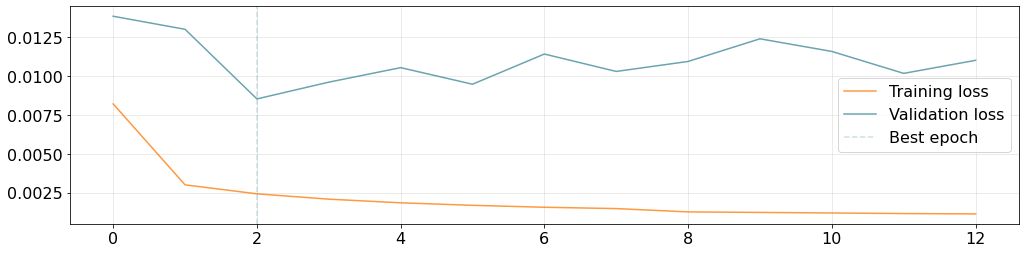

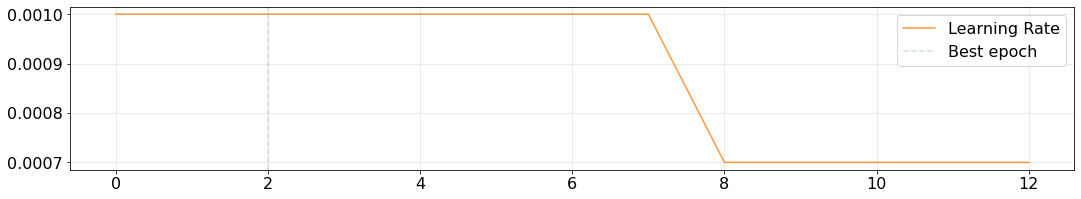

(3064, 16, 7)


In [ ]:

model.save(model_name)
#model = tfk.models.load_model('DirectForecasting')

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
#plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(17,4))
# #plt.plot(history[tf.keras.metrics.RootMeanSquaredError()], label='Training accuracy', alpha=.8, color='#ff7f0e')
# #plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# #plt.title('Mean Absolute Error')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)



0.0742874


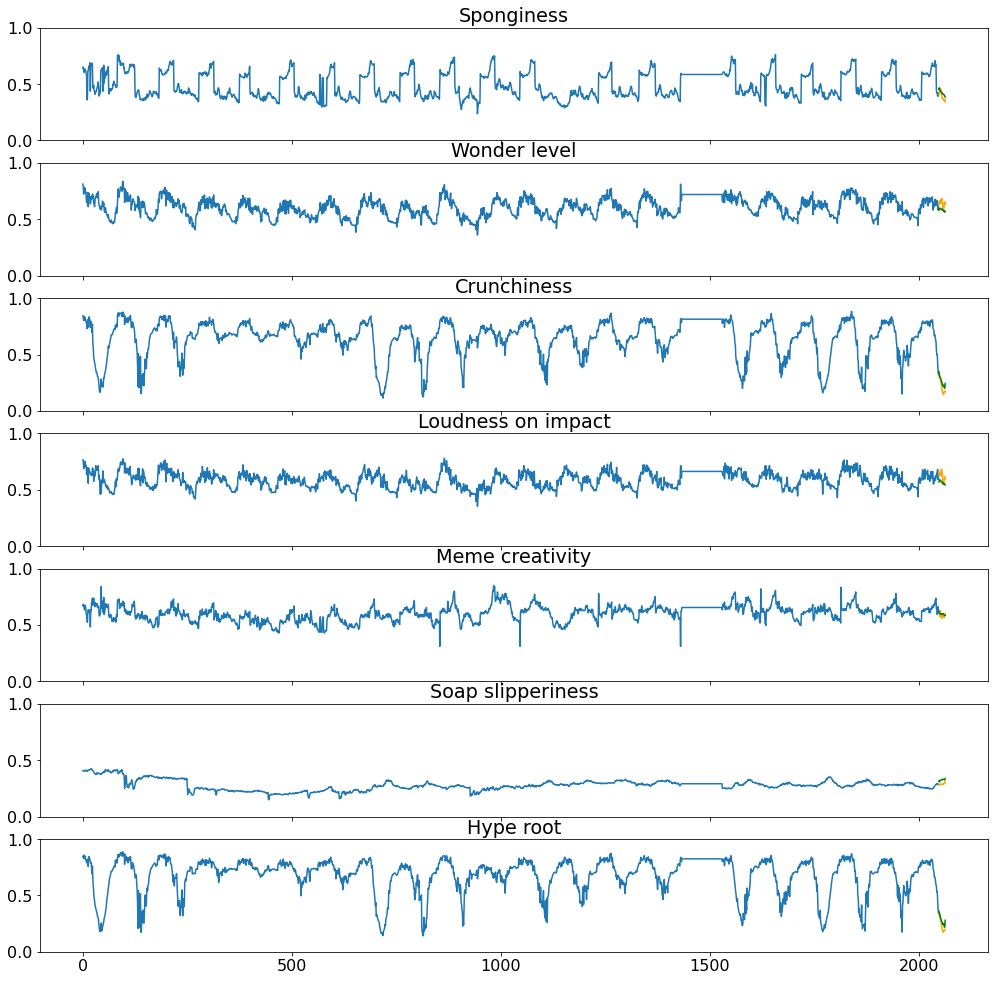

In [ ]:

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(y_test.flatten(),predictions.flatten())
print(m.result().numpy())

def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)


In [ ]:

#lo uso con l'autoregression

X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
print(X_test_reg.shape, y_test_reg.shape)

reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(int(reg_telescope/telescope)):
    print(reg*telescope)
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)



#lo uso col direct
'''
reg_telescope = telescope
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
predictions = model.predict(X_test)
reg_predictions = predictions
'''


(2640, 2048, 7) (2640, 864, 7)
0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848


'\nreg_telescope = telescope\nX_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)\npredictions = model.predict(X_test)\nreg_predictions = predictions\n'

(2640, 864, 7)
0.11068743


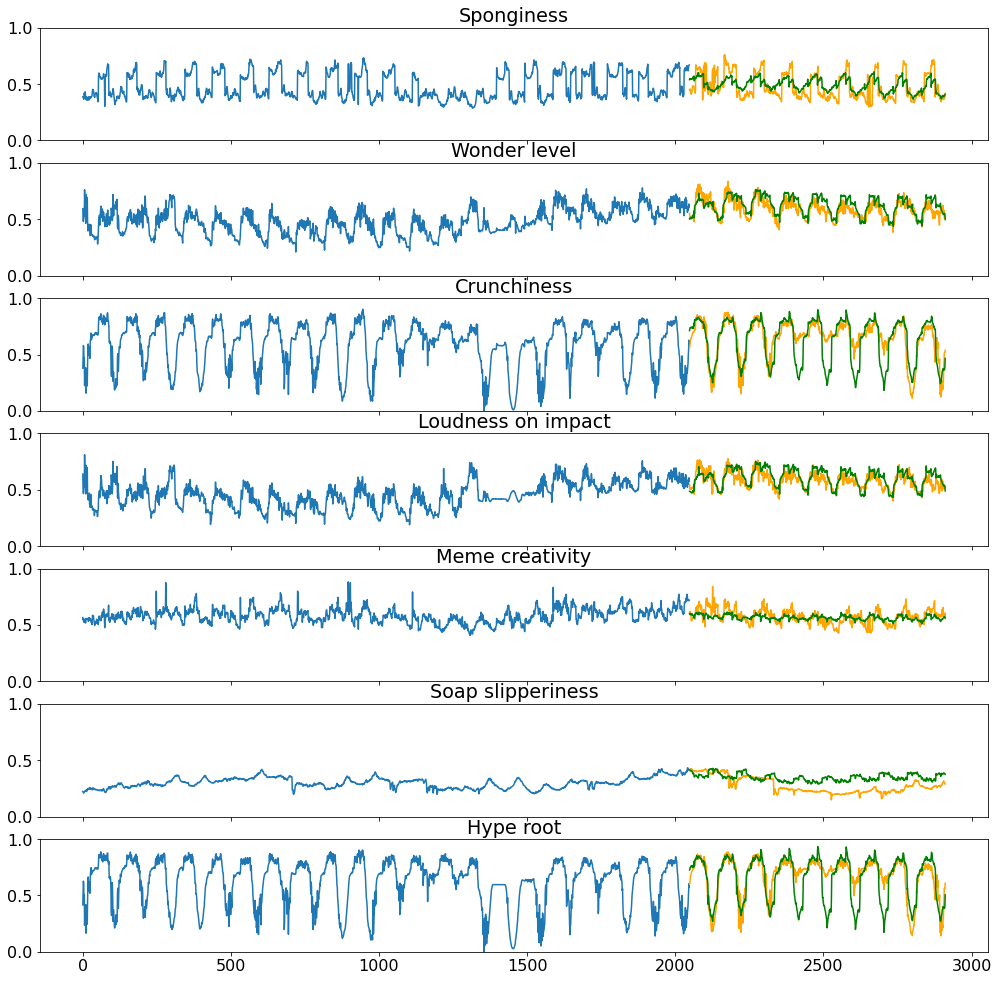

In [ ]:
#parte in comune

print(reg_predictions.shape)

# mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
# mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
# print(mean_squared_error, mean_absolute_error)
# print(tf.keras.metrics.RootMeanSquaredError(y_test_reg.flatten(),reg_predictions.flatten()))

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(y_test_reg.flatten(),reg_predictions.flatten())
print(m.result().numpy())

inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

